# style transfer
https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

In [42]:
from PIL import Image, ImageOps
import requests

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
vgg = models.vgg19(pretrained=True).features # we only want the features not the classification of this model
for param in vgg.parameters():
    param.requires_grad_(False) # same as param.requires_grad = False

In [44]:
vgg = vgg.to(device)
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [45]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert("RGB")
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])   
    image = in_transform(image).unsqueeze(0)
    return image   

def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() 
    image = image.transpose(1,2,0) 
    image = image * np.array([0.5])+ np.array([0.5]) 
    image.clip(0,1) #ensures range is between 0 and 1
    return image


In [46]:
img_path_content = "./data/style_transfer/Aurelien.jpg"
img_path_style = "./data/style_transfer/wave.jpg"
content = load_image(img_path_content).to(device)
style = load_image(img_path_style, shape=content.shape[-2:]).to(device)

In [47]:
style.shape, content.shape

(torch.Size([1, 3, 600, 400]), torch.Size([1, 3, 600, 400]))

(-0.5, 399.5, 599.5, -0.5)

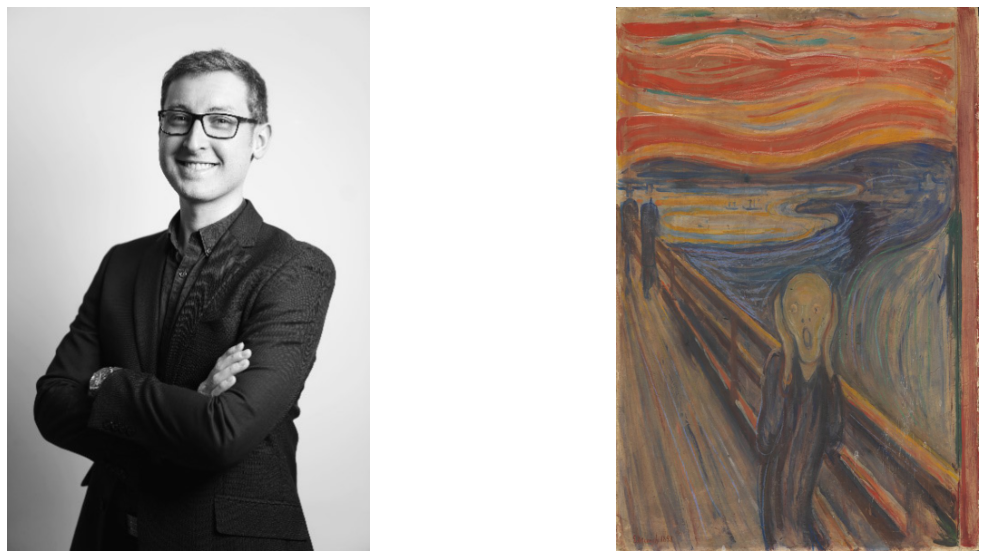

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(im_convert(content[0]))
ax1.axis("off")
ax2.imshow(im_convert(style[0]))
ax2.axis("off")

In [50]:
def get_features(image, model):

    layers = {
        "0": "conv1_1",
        "5": "conv2_1",
        "10": "conv3_1",
        "19": "conv4_1",
        "21": "conv4_2", # content extraction
        "28": "conv5_1", 
    }

    features = {}
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image

    return features


In [51]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [52]:
    def gram_matrix(tensor):
        _, d, h, w = tensor.size()
        tensor = tensor.view(d, h * w)
        gram = torch.mm(tensor, tensor.t())
        return gram

    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [53]:
    style_weights = {'conv1_1': 1.,
                     'conv2_1': 0.75,
                     'conv3_1': 0.2,
                     'conv4_1': 0.2,
                     'conv5_1': 0.2}
     
    content_weight = 1  # alpha
    style_weight = 1e6  # beta

    target = content.clone().requires_grad_(True).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  500363.28125
Iteration:  300


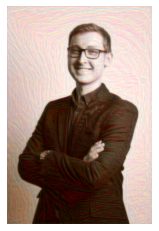

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  301719.96875
Iteration:  600


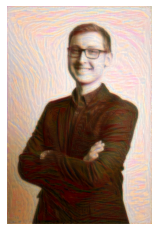

Total loss:  216861.53125
Iteration:  900
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


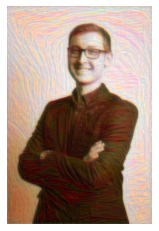

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  164618.90625
Iteration:  1200


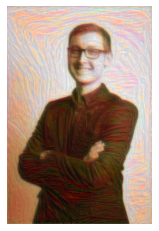

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  129800.09375
Iteration:  1500


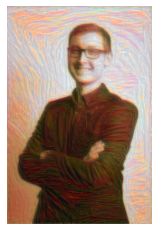

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  104711.2578125
Iteration:  1800


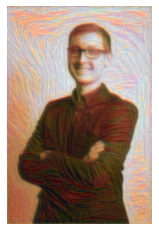

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  85247.671875
Iteration:  2100


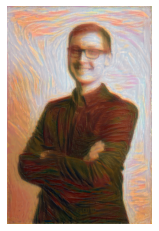

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  69392.78125
Iteration:  2400


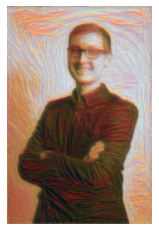

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  56083.7890625
Iteration:  2700


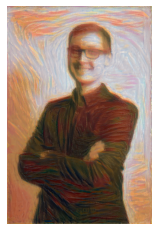

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  44874.73046875
Iteration:  3000


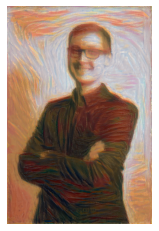

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  35744.08984375
Iteration:  3300


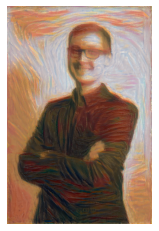

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  28672.404296875
Iteration:  3600


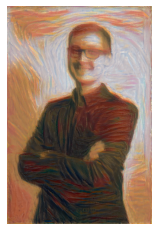

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  23522.232421875
Iteration:  3900


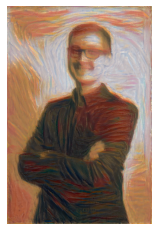

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  19297.521484375
Iteration:  4200


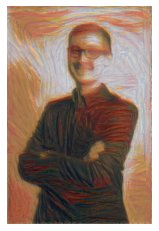

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  15959.4765625
Iteration:  4500


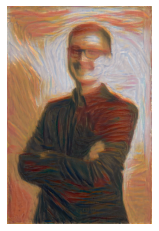

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  13901.9384765625
Iteration:  4800


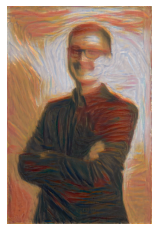

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Total loss:  11270.486328125
Iteration:  5100


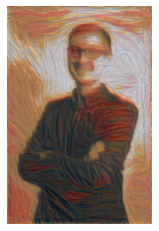

KeyboardInterrupt: 

In [54]:
    show_every = 300
    optimizer = torch.optim.Adam([target], lr=0.003)
    steps = 30000
     
    height, width, channels = im_convert(target[0]).shape
    image_array = np.empty(shape=(300, height, width, channels))
    capture_frame = steps/300
    counter = 0

    for ii in range(1, steps+1):
      target_features = get_features(target, vgg)
      content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
      style_loss = 0
      
      for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
      
      total_loss = content_weight * content_loss + style_weight * style_loss
      
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
      
      if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: ', ii)
        plt.imshow(im_convert(target[0]))
        plt.axis("off")
        plt.show()
        
      if ii % capture_frame == 0:
        image_array[counter] = im_convert(target[0])
        counter = counter + 1

In [13]:
import cv2 
    
frame_height, frame_width, _ = im_convert(target[0]).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))
    
for i in range(0, 300):
    img = image_array[i]
    img = img*255
    img = np.array(img, dtype = np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vid.write(img)
    
vid.release()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


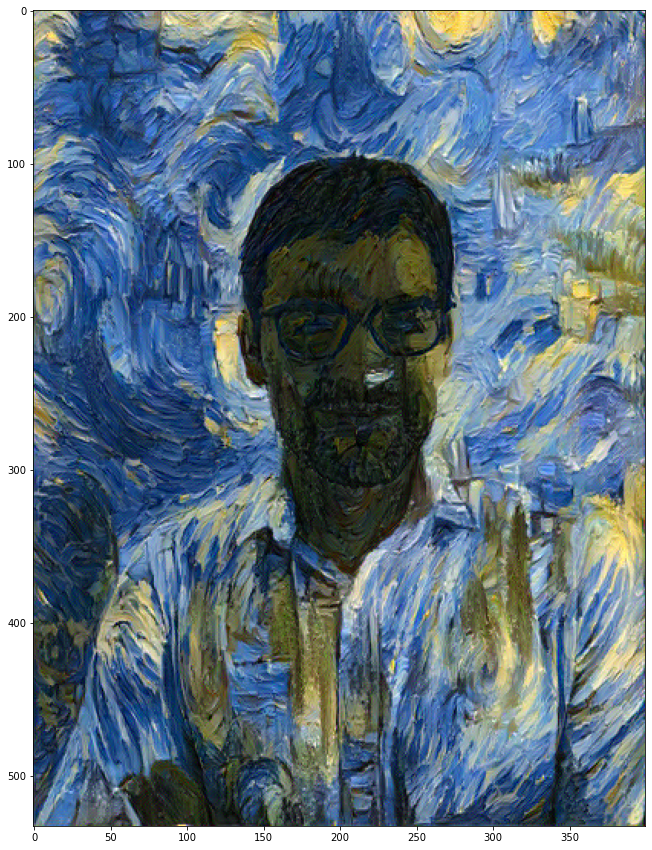

In [25]:
plt.figure(figsize=(15,15))
plt.imshow(im_convert(target[0]))

In [41]:
save_image(torch.Tensor(im_convert(target[0]).transpose(2,0,1)), "ee.png")